In [1]:
import numpy as np
import hyperspy.api as hys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
import tkinter.filedialog as tkf
import scipy.optimize as spopt
import scipy.fftpack as spfft
from sklearn.linear_model import Lasso
import skimage.transform as skt
import psutil

C:\Users\user\Anaconda3\envs\CS\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [2]:
img_adr = tkf.askopenfilename()

In [ ]:
Xorig = plt.imread(img_adr)
print(Xorig.shape)
#print(Xorig[0, 0, :])

X = Xorig#[:, :, 0]
print(X.shape)

In [3]:
X_dm = hys.load(img_adr)
X = X_dm.data
print(X.shape)
X = X[124:, 124:]
print(X.shape)

(1024, 1024)
(900, 900)


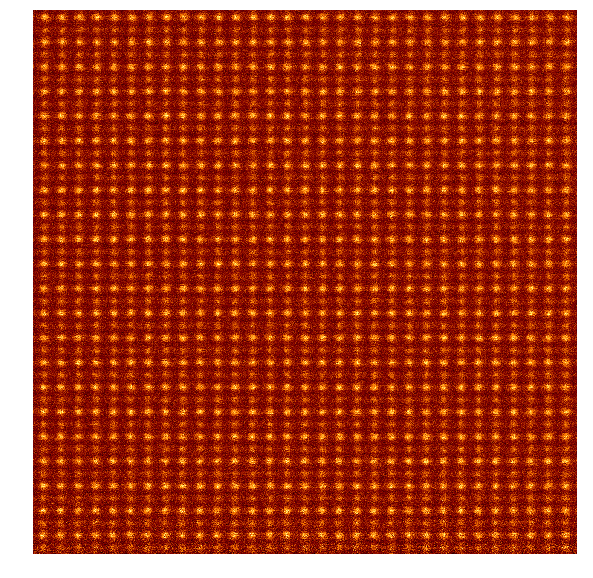

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(X, cmap="afmhot")
plt.axis("off")
plt.show()

In [16]:
def nmf(data_set, n_comp=5, vis_comp=False, projection=False, inverse=False, initialize="random"):
    print("Doing NMF...")

    nmf = NMF(n_components=n_comp, init=initialize, solver="mu", max_iter=500, random_state=56)
    nmf.fit(data_set)

    reduced_projection = nmf.transform(data_set)
    restore = nmf.inverse_transform(reduced_projection)
    
    if vis_comp:
        n1 = n_comp
        fig1, ax1 = plt.subplots(n1, 1, figsize=(10, n_comp))
        temp_flat = ax1.flat
        for i, ax in enumerate(temp_flat[:n1]):
            ax.plot(nmf.components_[i], "k-", c="black")
            ax.grid()
        #plt.show()
        #plt.close(fig1)

    if projection:
        fig2= plt.figure(figsize=(10,10))
        ax2 = fig2.add_subplot(221)
        ax2.scatter(reduced_projection[:, 0], reduced_projection[:, 1], s=1.5, c="black", alpha=0.5)
        ax2.grid()
        ax2.set_xlabel("component 1")
        ax2.set_ylabel("component 2")

        ax3 = fig2.add_subplot(222)
        ax3.scatter(reduced_projection[:, 1], reduced_projection[:, 2], s=1.5, c="black", alpha=0.5)
        ax3.grid()
        ax3.set_xlabel("component 2")
        ax3.set_ylabel("component 3")

        ax4 = fig2.add_subplot(223)
        ax4.scatter(reduced_projection[:, 0], reduced_projection[:, 2], s=1.5, c="black", alpha=0.5)
        ax4.grid()
        ax4.set_xlabel("component 1")
        ax4.set_ylabel("component 3")
        
        if n_comp > 2:
            ax5 = fig2.add_subplot(224, projection="3d")
            ax5.scatter(reduced_projection[:, 0], reduced_projection[:, 1],reduced_projection[:, 2], zdir="z", s=1.5, c="black", alpha=0.5)
            ax5.grid()
            ax5.set_xlabel("component 1")
            ax5.set_ylabel("component 2")
            ax5.set_zlabel("component 3")
        #plt.show()
        #plt.close(fig2)

    if inverse:
        fig3, ax6 = plt.subplots(10, 2, figsize=(10, 20))
        for i in range(10):
            ax6[i, 0].plot(data_set[i], c="blue")
            ax6[i, 0].grid()
            ax6[i, 1].plot(restore[i], c="crimson")
            ax6[i, 1].grid()
        #plt.show()
        #plt.close(fig3)

    return nmf.components_, reduced_projection, restore

# NMF

Doing NMF...


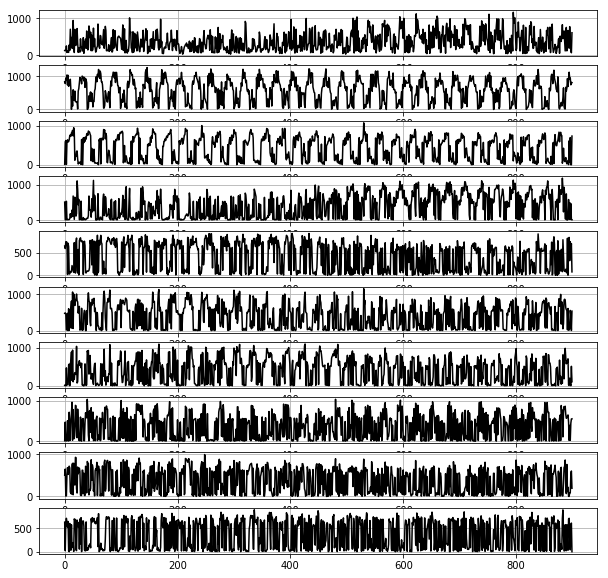

In [17]:
comp_vectors_nmf, projections_nmf, restoration_nmf = nmf(X, n_comp=10, vis_comp=True, projection=False, inverse=False, initialize="nndsvda")
plt.show()

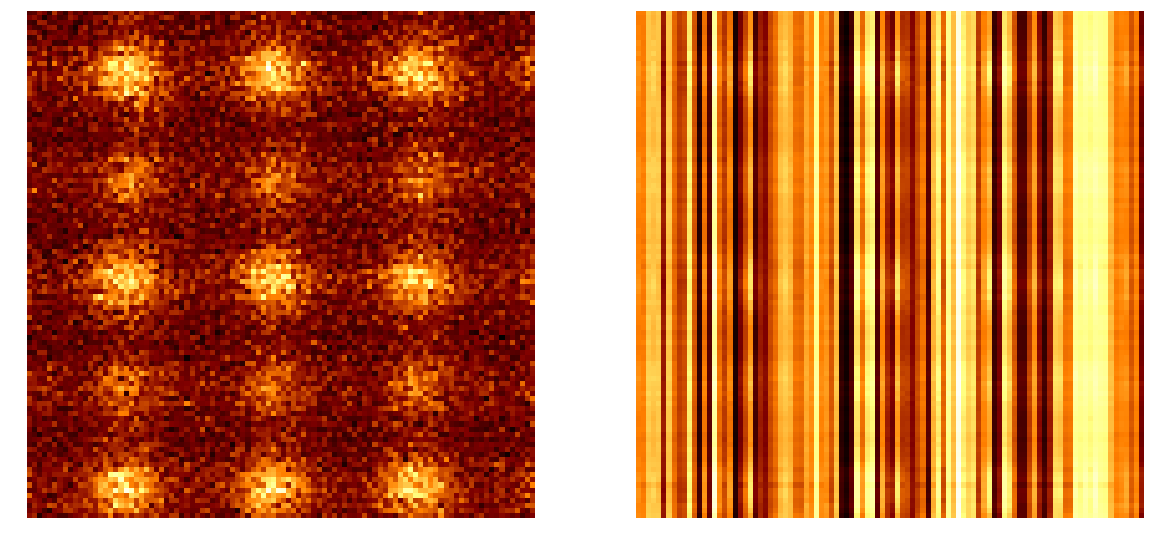

In [18]:
# NMF : reconstruction

num_comp = 5
comp_array = np.arange(num_comp) # or you can create manually

#comp_array = [0, 9]

reconstructed_nmf = np.dot(projections_nmf[:, comp_array], comp_vectors_nmf[comp_array])
        
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(X[:100, :100], cmap="afmhot")
ax[0].axis("off")
ax[1].imshow(reconstructed_nmf[:100, :100], cmap="afmhot")
ax[1].axis("off")
plt.show()

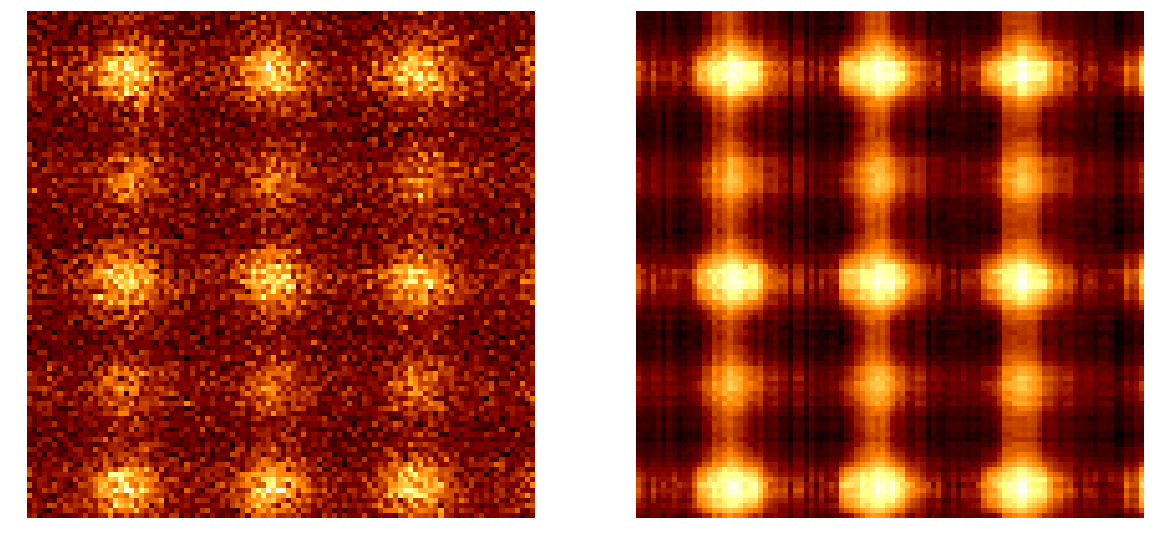

In [19]:
# NMF : reconstruction (all components involved)

fig, ax = plt.subplots(1, 2, figsize=(20, 30))
ax[0].imshow(X[:100, :100], cmap="afmhot")
ax[0].axis("off")
ax[1].imshow(restoration_nmf[:100, :100], cmap="afmhot")
ax[1].axis("off")
plt.show()

In [ ]:
save_adr = tkf.asksaveasfilename()
plt.imsave(fname=save_adr, arr=restoration_nmf, format="png", cmap="gray")

In [6]:
def pca(data_set, eigenvector=False, projection=None, inverse=False, n_comp=100, solver="auto"):
    print("Doing PCA...")

    pca = PCA(n_components=n_comp, svd_solver=solver, whiten=False)
    pca.fit(data_set)
    print(pca.explained_variance_ratio_)
    print(np.sum(pca.explained_variance_ratio_))

    fig1, ax1 = plt.subplots(figsize=(5,3))
    ax1.plot(np.cumsum(pca.explained_variance_ratio_), c="darkslategrey")
    ax1.grid()
    ax1.set_xlabel('number of components')
    ax1.set_ylabel('cumulative explained variance')
    #print len(pca.components_)
    #plt.show()
    #plt.close(fig1)

    reduced_projection = pca.transform(data_set)
    restore = pca.inverse_transform(reduced_projection)
        
    if eigenvector:
        fig2, ax2 = plt.subplots(n_comp, 1, figsize=(10, n_comp))
        temp_flat = ax2.flat
        for i, ax in enumerate(temp_flat[:n_comp]):
            ax.plot(pca.components_[i], c="darkslategrey")
            ax.grid()
        #plt.show()
        #plt.close(fig2)

    if projection:
        fig3= plt.figure(figsize=(10,10))
        ax3 = fig3.add_subplot(221)
        ax3.scatter(reduced_projection[:, 0], reduced_projection[:, 1], s=1.5, c="darkslategrey")
        ax3.grid()
        ax3.set_xlabel("component 1")
        ax3.set_ylabel("component 2")

        ax4 = fig3.add_subplot(222)
        ax4.scatter(reduced_projection[:, 1], reduced_projection[:, 2], s=1.5, c="darkslategrey")
        ax4.grid()
        ax4.set_xlabel("component 2")
        ax4.set_ylabel("component 3")

        ax5 = fig3.add_subplot(223)
        ax5.scatter(reduced_projection[:, 0], reduced_projection[:, 2], s=1.5, c="darkslategrey")
        ax5.grid()
        ax5.set_xlabel("component 1")
        ax5.set_ylabel("component 3")
        
        if n_comp > 2:
            ax6 = fig3.add_subplot(224, projection="3d")
            ax6.scatter(reduced_projection[:, 0], reduced_projection[:, 1],reduced_projection[:, 2], zdir="z", s=1.5, c="darkslategrey")
            ax6.grid()
            ax6.set_xlabel("component 1")
            ax6.set_ylabel("component 2")
            ax6.set_zlabel("component 3")
        
        #plt.show()
        #plt.close(fig3)

    if inverse:
        n2 = 10
        fig4, ax7 = plt.subplots(n2, 2, figsize=(10,20))
        for i in range(n2):
            ax7[i, 0].plot(data_set[i], c="blue")
            ax7[i, 0].grid()
            ax7[i, 1].plot(restore[i], c="crimson")
            ax7[i, 1].grid()
        #fig4.tight_layout()
        #plt.show()
        #plt.close(fig4)
        
    return pca.components_, pca.mean_, reduced_projection, restore

#  PCA : row

Doing PCA...
[0.4287827  0.01697527 0.00369111 0.00335262 0.00328931 0.00309443
 0.00284324 0.00277088 0.0027333  0.00271503]
0.47024788255258615


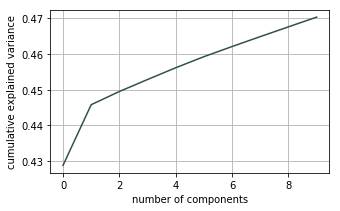

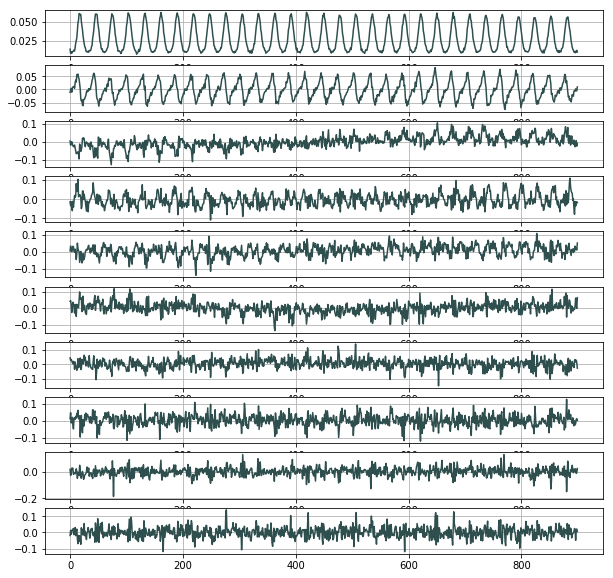

In [7]:
comp_vectors_pca, mean_pca, projections_pca, restoration_pca = pca(X, n_comp=10, eigenvector=True, projection=False, inverse=False)
plt.show()

1266
1051.6452407714075


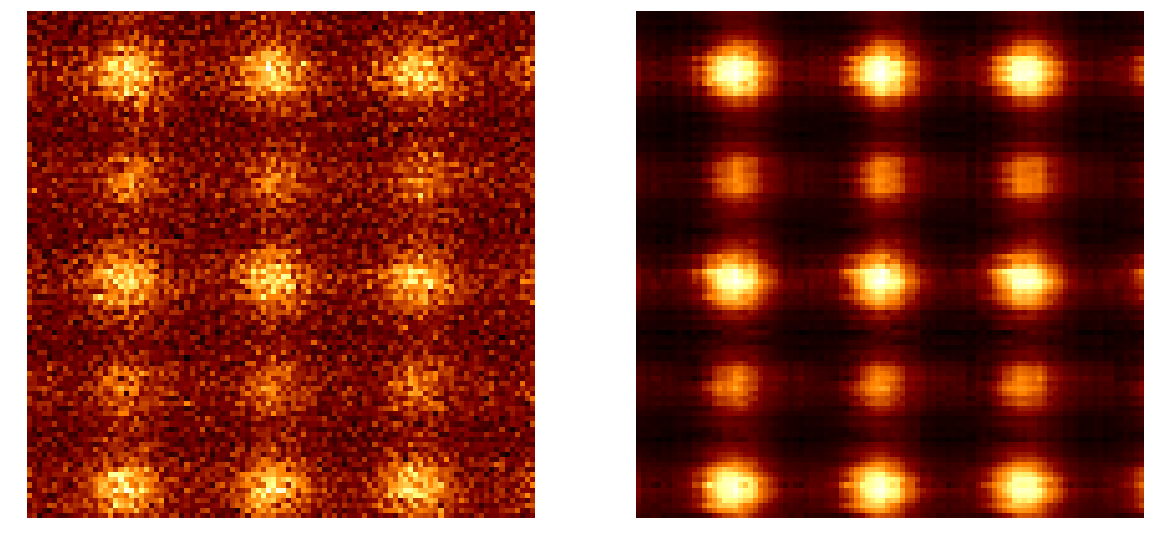

In [8]:
# PCA : reconstruction

num_comp = 5
comp_array = np.arange(num_comp) # or you can create manually

reconstructed_pca = np.dot(projections_pca[:, comp_array], comp_vectors_pca[comp_array]) + mean_pca
        
print(np.max(X))
print(np.max(reconstructed_pca))
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(X[:100, :100], cmap="afmhot")
ax[0].axis("off")
ax[1].imshow(reconstructed_pca[:100, :100], cmap="afmhot")
ax[1].axis("off")
plt.show()

1266
1102.8483912085098


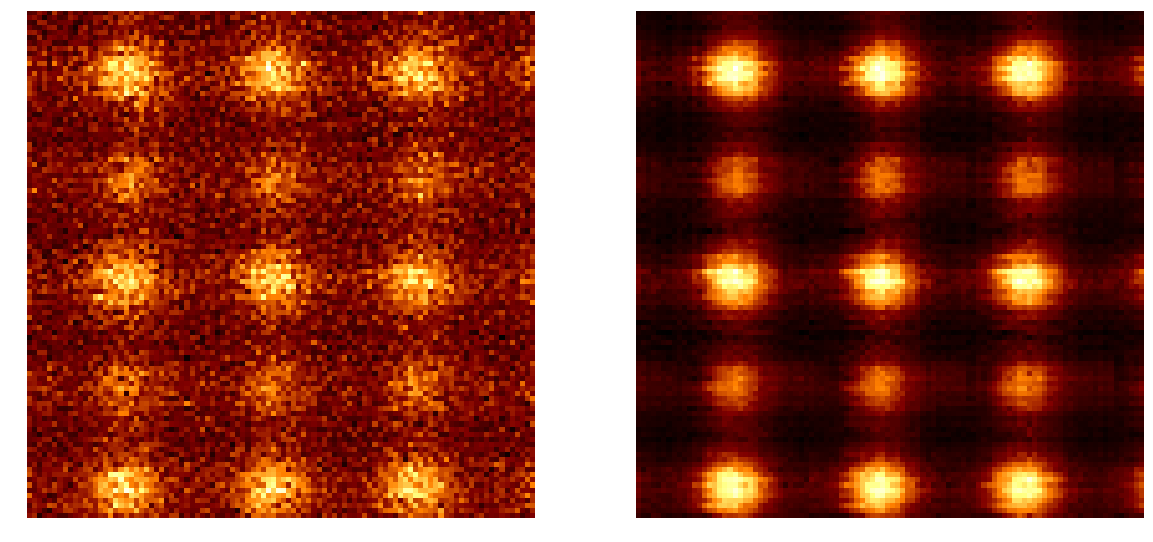

In [9]:
# PCA : reconstruction (all components involved)
print(np.max(X))
print(np.max(restoration_pca))

fig, ax = plt.subplots(1, 2, figsize=(20, 30))
ax[0].imshow(X[:100, :100], cmap="afmhot")
ax[0].axis("off")
ax[1].imshow(restoration_pca[:100, :100], cmap="afmhot")
ax[1].axis("off")
plt.show()

In [ ]:
save_adr = tkf.asksaveasfilename()
plt.imsave(fname=save_adr, arr=reconstructed_pca, format="png", cmap="gray")

# PCA : column

Doing PCA...
[0.4359092  0.01748328 0.00389112 0.00331476 0.0031221  0.00302832
 0.00275312 0.00272203 0.0026942  0.00267329]
0.47759142571216123


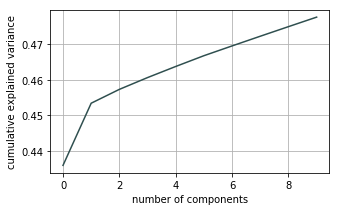

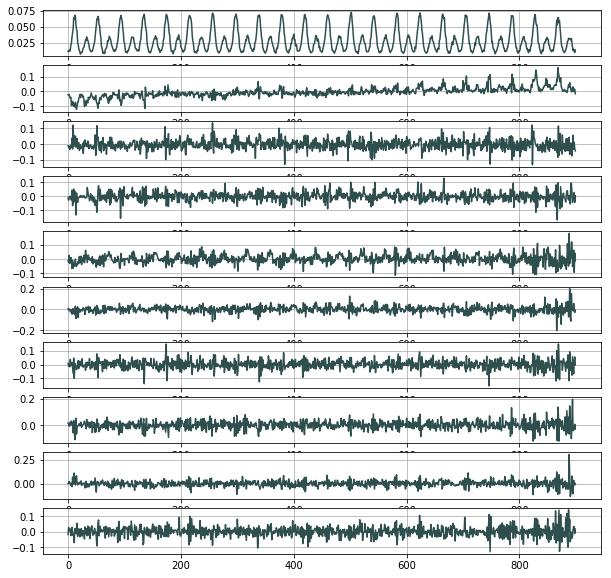

In [10]:
comp_vectors_pca_T, mean_pca_T, projections_pca_T, restoration_pca_T = pca(X.T, n_comp=10, eigenvector=True, projection=False, inverse=False)
plt.show()

1266
1049.0453798516896


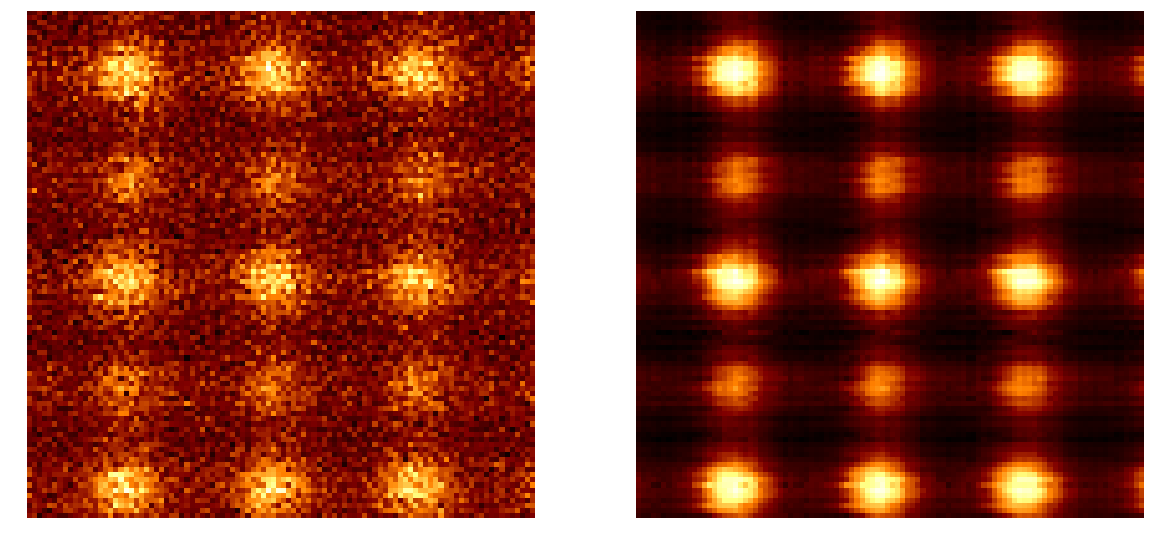

In [13]:
# PCA : reconstruction

num_comp = 5
comp_array = np.arange(num_comp) # or you can create manually

reconstructed_pca_T = np.dot(projections_pca_T[:, comp_array], comp_vectors_pca_T[comp_array]) + mean_pca_T
        
print(np.max(X))
print(np.max(reconstructed_pca_T))
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(X[:100, :100], cmap="afmhot")
ax[0].axis("off")
ax[1].imshow(reconstructed_pca_T.T[:100, :100], cmap="afmhot")
ax[1].axis("off")
plt.show()

1266
1085.9884191729157


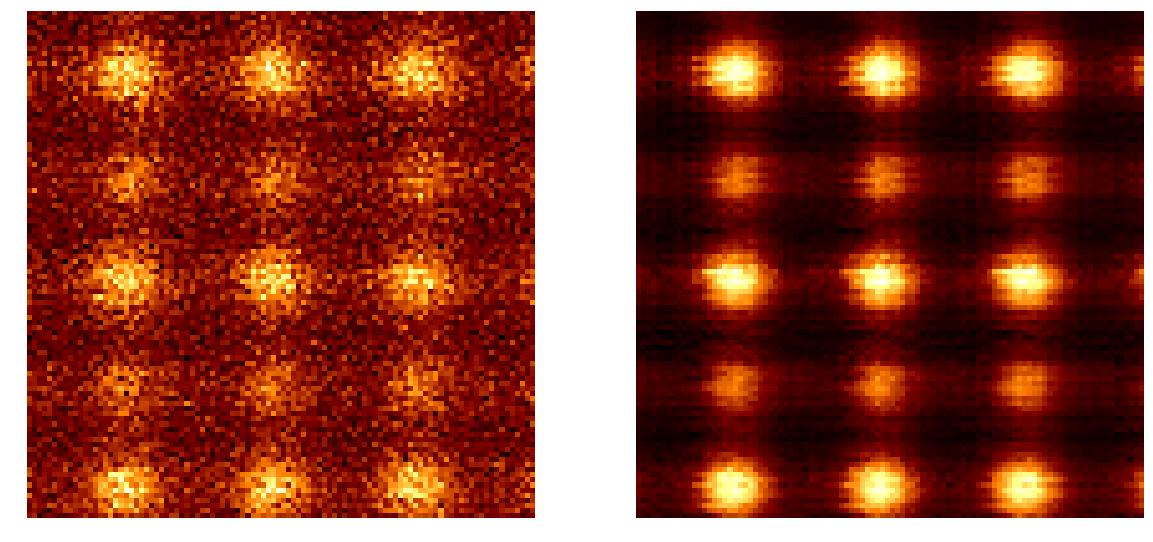

In [12]:
# PCA : reconstruction (all components involved)
print(np.max(X))
print(np.max(restoration_pca_T))

fig, ax = plt.subplots(1, 2, figsize=(20, 30))
ax[0].imshow(X[:100, :100], cmap="afmhot")
ax[0].axis("off")
ax[1].imshow(restoration_pca_T.T[:100, :100], cmap="afmhot")
ax[1].axis("off")
plt.show()

In [ ]:
save_adr = tkf.asksaveasfilename()
plt.imsave(fname=save_adr, arr=reconstructed_pca_T, format="png", cmap="gray")

# PCA : row & column

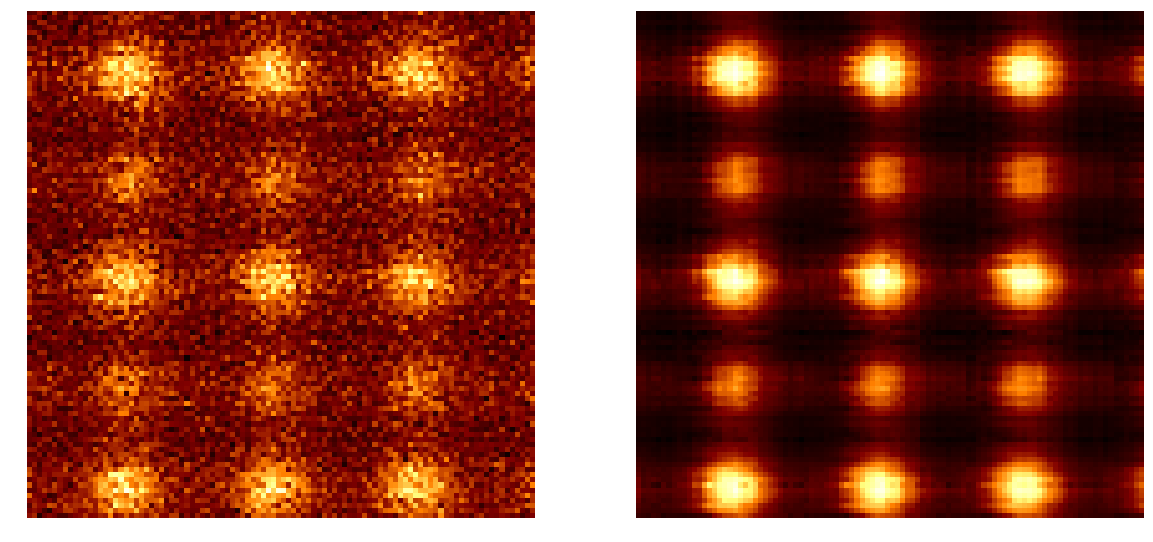

In [14]:
substraction = reconstructed_pca / np.max(reconstructed_pca) - reconstructed_pca_T.T / np.max(reconstructed_pca_T)
correction_1 = reconstructed_pca - substraction

fig, ax = plt.subplots(1, 2, figsize=(20, 30))
ax[0].imshow(X[:100, :100], cmap="afmhot")
ax[0].axis("off")
ax[1].imshow(correction_1[:100, :100], cmap="afmhot")
ax[1].axis("off")
plt.show()

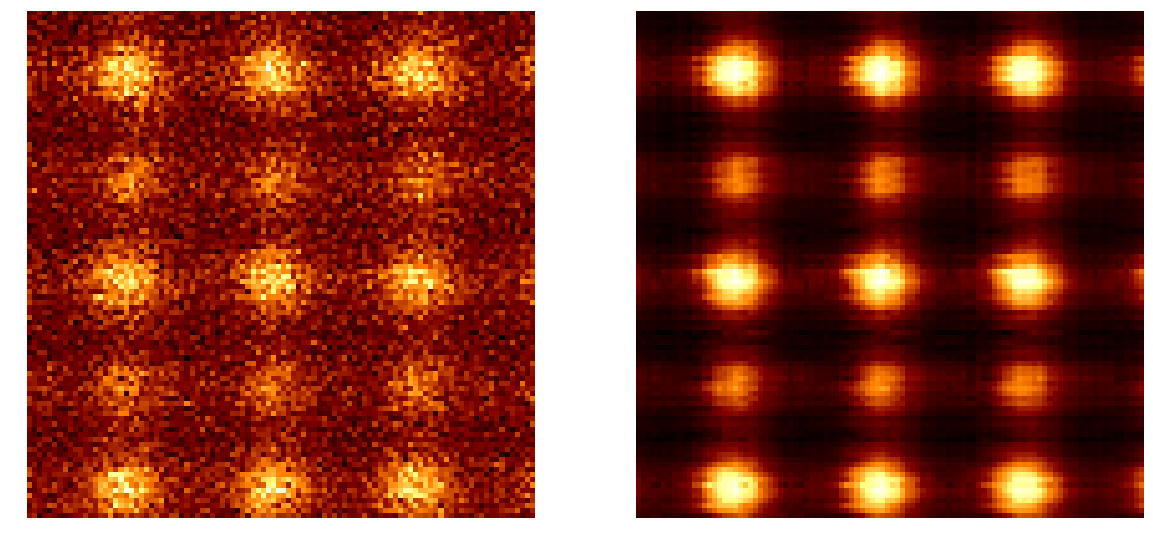

In [15]:
addition = 0.5 * reconstructed_pca / np.max(reconstructed_pca) + 0.5 * reconstructed_pca_T.T / np.max(reconstructed_pca_T)
fig, ax = plt.subplots(1, 2, figsize=(20, 30))
ax[0].imshow(X[:100, :100], cmap="afmhot")
ax[0].axis("off")
ax[1].imshow(addition[:100, :100], cmap="afmhot")
ax[1].axis("off")
plt.show()